In [1]:
import torch
from torch import nn

import numpy as np
import scipy as sp

from collections import namedtuple
from tqdm import tqdm

import matplotlib.pyplot as plt

from skimage import io
from torchvision import transforms
import torchvision
import skimage
from PIL import Image

In [2]:
import os
def collect_images_paths():
    images = []
    dirs = os.listdir('images')
    for dir in dirs:
        images += [f"images/{dir}/{file}" for file in os.listdir(f'images/{dir}')]
    return images

In [3]:
all_img_paths = collect_images_paths()
all_img_paths[:10], len(all_img_paths)

(['images/busystreet/0001.jpg',
  'images/busystreet/0002.jpg',
  'images/busystreet/0003.jpg',
  'images/busystreet/0004.jpg',
  'images/busystreet/0005.jpg',
  'images/busystreet/0006.jpg',
  'images/busystreet/0007.jpg',
  'images/busystreet/0008.jpg',
  'images/busystreet/0009.jpg',
  'images/busystreet/0010.jpg'],
 13470)

In [149]:
TRAIN_NUM = 200
TEST_NUM = 40

img_paths = np.random.choice(all_img_paths, TRAIN_NUM + TEST_NUM, replace=False)
len(img_paths)

240

In [150]:
train_paths = img_paths[:TRAIN_NUM]
test_paths = img_paths[TRAIN_NUM:]
len(train_paths), len(test_paths)

(200, 40)

In [151]:
transform_preprocess_img = transforms.Compose([
    transforms.CenterCrop(512),
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Grayscale()
])

In [152]:
def image_loader(pathlist):
    for p in pathlist:
        yield transform_preprocess_img(Image.open(p))

In [153]:
def show(img):
    plt.imshow(np.moveaxis(np.asarray(img), (0,1,2), (2,0,1)), cmap='gray')


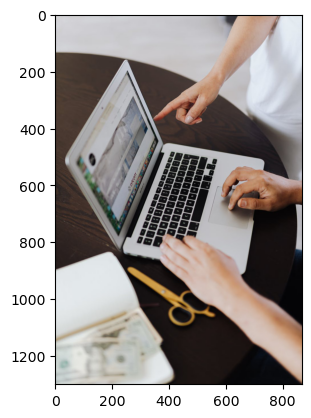

In [154]:
plt.imshow(Image.open(train_paths[0]))

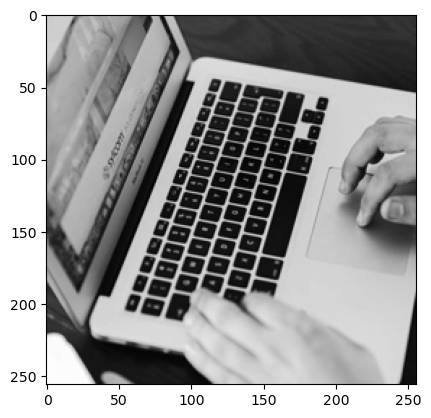

In [155]:
sample = next(image_loader(train_paths))
show(sample)

In [158]:
def ruin_image(img, factor=0.5):
    return transforms.Resize(256, transforms.InterpolationMode.NEAREST)(transforms.Resize(int(256*factor), transforms.InterpolationMode.NEAREST)(img))

def ruin_image_gen(img_list, factor=0.5):
    for img in img_list:
        yield ruin_image(img, factor)

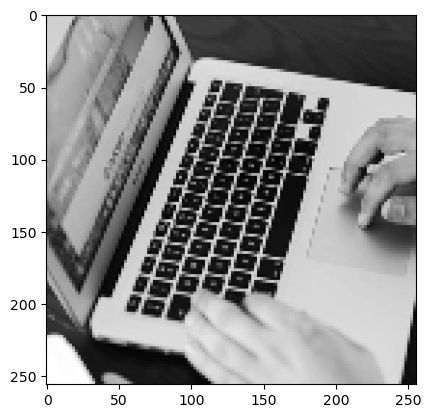

In [159]:
show(ruin_image(sample))

---

In [177]:
%%time

train_images_out = list(image_loader(tqdm(train_paths)))
train_images_in = list(ruin_image_gen(tqdm(train_images_out)))

test_images_out = list(image_loader(test_paths))
test_images_in = list(ruin_image_gen(test_images_out))

 98%|█████████▊| 39/40 [00:00<00:00, 39002.83it/s]

CPU times: total: 51.7 s
Wall time: 16.3 s


In [186]:
GLOBAL_MEAN = torch.stack(train_images_out).mean()
GLOBAL_STD = torch.stack(train_images_out).std()

In [187]:
GLOBAL_MEAN, GLOBAL_STD

(tensor(0.3938), tensor(0.2876))

In [190]:
def normalize(img_list):
    normalizer = transforms.Normalize(mean=GLOBAL_MEAN, std=GLOBAL_STD)
    return [normalizer(img) for img in img_list]
    
train_images_out = normalize(train_images_out)
train_images_in = normalize(train_images_in)
test_images_out = normalize(test_images_out)
test_images_in = normalize(test_images_in)

In [192]:
train_dataset = list(zip(train_images_in, tqdm(train_images_out)))
test_dataset = list(zip(test_images_in, tqdm(test_images_out)))

 98%|█████████▊| 39/40 [00:00<?, ?it/s]


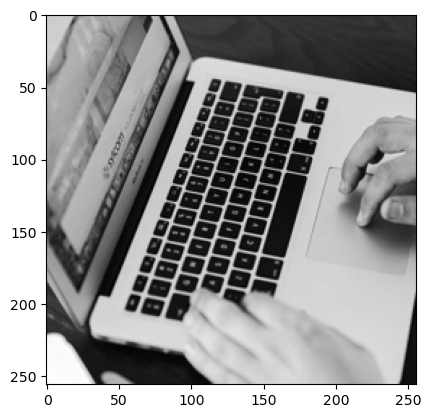

In [191]:
show(train_images_out[0])

In [194]:
def get_dataloaders():
    return train_dataset, test_dataset

---

In [145]:
# nn.Conv2d - Applies a 2D convolution [of weight matrix] over an input signal composed of several input planes.
# Noteworthy params:
# - in_channels
# - out_channels 
# - kernel_size
# - padding

# Theory based on https://www.intel.com/content/www/us/en/developer/articles/technical/an-example-of-a-convolutional-neural-network-for-image-super-resolution.html
# Code based on https://github.com/Fivefold/SRCNN/blob/main/Torch/models.py

SRCNNParams = namedtuple("Params", 'c, f1, f2, f3, n1, n2, n3')
default_params = SRCNNParams(
    # color components (channels)
    c = 1,  
    
    # filter sizes (f*f)
    f1 = 9,
    f2 = 1,
    f3 = 5,
    
    # number of filters (layer size)
    n1 = 64,
    n2 = 32,
    n3 = 1    # should be equal to `c`
)

class SRCNN(nn.Module):
    def __init__(self, params, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(params.c, params.n1, kernel_size=params.f1, padding=params.f1 // 2)
        self.conv2 = nn.Conv2d(params.n1, params.n2, kernel_size=params.f2, padding=params.f2 // 2)
        self.conv3 = nn.Conv2d(params.n2, params.c, kernel_size=params.f3, padding=params.f3 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [160]:
def train(model, device, train_loader, loss_func, optimizer, epoch, total):
    model.train()
    train_losses = []
    print(f"Epoch {epoch}")
    for obs in tqdm(train_loader, total=total):
        img, target = obs
        img, target = img.to(device), target.to(device)
        optimizer.zero_grad()  # reset gradients
        output = model(img)   # forward propagation
        loss = loss_func(output, target)   # loss
        loss.backward()        # backward propagation
        optimizer.step()       # optimize weights based on backpropagation
        train_losses.append(loss.item())
    print(f"> loss={train_losses[-1]}")
    return np.array(train_losses)


def test(model, device, test_loader, loss_func):
    model.eval()
    test_loss = 0
    with torch.no_grad():  # we will need only forward propagation. no need to calculate grads.
        for obs in test_loader:
            img, target = obs
            img, target = img.to(device), target.to(device)
            output = model(img)
            test_loss += loss_func(output, target).item() * img.size(0)
    test_loss /= len(test_loader)
    print('Test: Average loss: {:.4f}\n'.format(test_loss))
    return test_loss

In [196]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using CUDA device' if torch.cuda.is_available() else 'Using CPU device')
model = SRCNN(default_params).to(device)

loss_func = nn.MSELoss()    # Mean Square Error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

Using CPU device


In [197]:
%%time
epochs = 10
losses = np.array([])
test_losses = []
for epoch in range(1, epochs+1):
    train_dataloader, test_dataloader = get_dataloaders()
    train_loss = train(model, device, train_dataloader, loss_func, optimizer, epoch, total=TRAIN_NUM)
    losses = np.append(losses, train_loss)
    print("> evaluating...")
    test_loss = test(model, device, tqdm(test_dataloader, total=TEST_NUM), loss_func)
    test_losses.append(test_loss)

Epoch 1


100%|██████████| 200/200 [00:41<00:00,  4.86it/s]


> loss=0.013803593814373016
> evaluating...


100%|██████████| 40/40 [00:02<00:00, 15.37it/s]


Test: Average loss: 0.0273

Epoch 2


100%|██████████| 200/200 [00:41<00:00,  4.82it/s]


> loss=0.01317113172262907
> evaluating...


100%|██████████| 40/40 [00:02<00:00, 15.53it/s]


Test: Average loss: 0.0231

Epoch 3


100%|██████████| 200/200 [00:41<00:00,  4.84it/s]


> loss=0.007731277495622635
> evaluating...


100%|██████████| 40/40 [00:02<00:00, 15.35it/s]


Test: Average loss: 0.0216

Epoch 4


100%|██████████| 200/200 [00:41<00:00,  4.85it/s]


> loss=0.009994328953325748
> evaluating...


100%|██████████| 40/40 [00:02<00:00, 14.94it/s]


Test: Average loss: 0.0239

Epoch 5


100%|██████████| 200/200 [00:41<00:00,  4.86it/s]


> loss=0.006764865014702082
> evaluating...


100%|██████████| 40/40 [00:02<00:00, 15.91it/s]


Test: Average loss: 0.0200

Epoch 6


100%|██████████| 200/200 [00:41<00:00,  4.81it/s]


> loss=0.006306443363428116
> evaluating...


100%|██████████| 40/40 [00:02<00:00, 14.86it/s]


Test: Average loss: 0.0197

Epoch 7


100%|██████████| 200/200 [00:41<00:00,  4.82it/s]


> loss=0.005379237700253725
> evaluating...


100%|██████████| 40/40 [00:02<00:00, 14.75it/s]


Test: Average loss: 0.0188

Epoch 8


100%|██████████| 200/200 [00:41<00:00,  4.86it/s]


> loss=0.004805879667401314
> evaluating...


100%|██████████| 40/40 [00:02<00:00, 15.15it/s]


Test: Average loss: 0.0184

Epoch 9


100%|██████████| 200/200 [00:41<00:00,  4.83it/s]


> loss=0.004455032292753458
> evaluating...


100%|██████████| 40/40 [00:02<00:00, 14.80it/s]


Test: Average loss: 0.0180

Epoch 10


100%|██████████| 200/200 [00:41<00:00,  4.84it/s]


> loss=0.00530471745878458
> evaluating...


100%|██████████| 40/40 [00:02<00:00, 15.60it/s]

Test: Average loss: 0.0185

CPU times: total: 26min 49s
Wall time: 7min 19s


In [198]:
torch.save(model, 'srcnn.model')

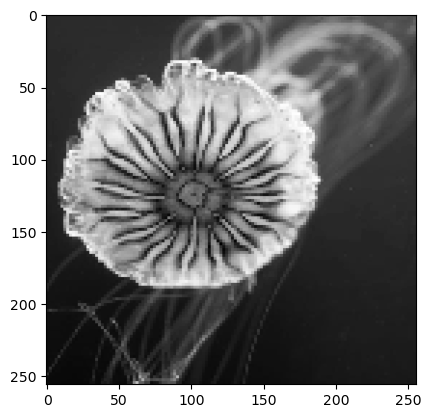

In [204]:
sample = test_images_out[15]
ruined = ruin_image(sample)
show(ruined)

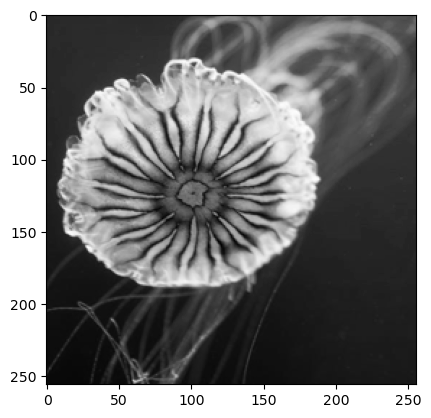

In [205]:

show(sample)

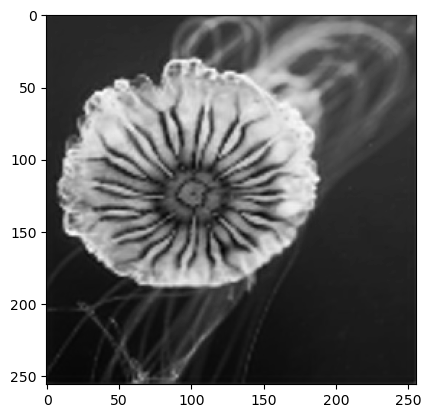

In [206]:
show(model(ruined).detach().numpy())